In [55]:
# load libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import models, layers, mixed_precision
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve

# # ignore warnings
# import warnings
# warnings.filterwarnings('ignore')


On my MacOS, I had issues with tensorflow -> if I just use `!pip install tensorflow`, it installs the incorrect tensorflow.  
I had to do `!pip install tensorflow-macos tensorflow-metal`

documentation:
https://stackoverflow.com/questions/65770132/python3-install-of-tensorflow-on-apple-silicon-m1/65771710

In [3]:
print(tensorflow.__version__)
print(tensorflow.config.list_physical_devices())  # should list a GPU on Apple Silicon


2.16.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
mixed_precision.set_global_policy('mixed_float16')

Data link:
https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset/data

In [ ]:
# load in data

# constants
BASE_DIR = "/Users/kbaik/Desktop/I320D ML/Group Project/archive"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 47

# Load full datasets
# split the train dataset into train/validation
train_dataset = tensorflow.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True
)

val_dataset = tensorflow.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True
)

test_dataset = tensorflow.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

print("Train classes:", train_dataset.class_names)
print("Validation classes:", val_dataset.class_names)
print("Test classes:", test_dataset.class_names)


Found 11879 files belonging to 2 classes.
Using 9504 files for training.
Found 11879 files belonging to 2 classes.
Using 2375 files for validation.
Found 2000 files belonging to 2 classes.
Train classes: ['Benign', 'Malignant']
Train classes: ['Benign', 'Malignant']
Test classes: ['Benign', 'Malignant']


2025-11-13 20:24:12.824182: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-13 20:24:12.824208: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-13 20:24:12.824215: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-13 20:24:12.824233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-13 20:24:12.824245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


I had to set shuffle=True for train_dataset and val_dataset because when set to False, val_dataset only had images with one label. This caused val_auc in the later training to come out as 0 only.

In [ ]:
# preprocessing
# documentation: 
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/guide/data_performance

# # normalize pixel values
# normalization_layer = tensorflow.keras.layers.Rescaling(1./255)

# train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
# test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# optimization
AUTOTUNE = tensorflow.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# data augmentation
data_augmentation = tensorflow.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1)
])

normalization is commented out because it is applied when the model is built or loaded.

shuffle() is only used on train dataset because of how the dataset is structured. The first 5000+ images will be only Benign Cancer images where the model can start learning in a biased way.
prefetch and cache is used for better performance.
please refer to the documentation.

In [ ]:
# create CNN model

cnn_model = models.Sequential()
cnn_model.add(data_augmentation) # apply data augmentation every time image is fed inot the model
cnn_model.add(layers.Rescaling(1./255, input_shape=(224,224,3))) # data normalization: pixel values changes from [0, 255] to [0, 1]

# 4 sets of convolutional and pooling blocks
cnn_model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(64, (3,3), activation='relu'))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(128, (3,3), activation='relu'))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(256, (3,3), activation='relu'))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D(2,2))

# decision making layers
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(1, activation='sigmoid', dtype='float32')) # final output

# compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-3), 
    loss='binary_crossentropy', 
    metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')])

cnn_model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

data augmentation helps prevent overfitting and improve generalization as it changes the images slightly.  
normalizing the image to a small consistent range is better for the model to learn consistently and is a standard in CNN models for image classification. Think of it as standard scaling that we learned and used in class.  
We are using 4 blocks of convolusional and pooling layers with batch normalizationa since our image sizes are 224 pixels. This allows the model to apply 256 filters and learn abstract features in the images.  
dropout of 0.5 which 50% is also widely used in CNN models to prevent overfitting as it provides regularization. What it does is it drops 50% of the neurons to 0 during training in each layer. This value was also originally proposed in 2014 Hinton paper.
`activation=sigmoid` was used since it maps a real number to a probability between 0 and 1 and is perfect for binary classification.
We chose adam as our optimzer as it was the industry standard. We had choices like AdamW which has weught decay for better generalization or RMSprop which is also used quite frequently in medical CNN models but we did not have the time or resources to test with each optimizers.

* paper: “Dropout: A Simple Way to Prevent Neural Networks from Overfitting” (Journal of Machine Learning Research, 2014) — Srivastava, Hinton, Krizhevsky, Sutskever & Salakhutdinov
link: https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf

two-phase fine-tuning  
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

https://pubmed.ncbi.nlm.nih.gov/26978662/

In [ ]:
# retrieve backbone of B0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False # freeze layers for phase 1 fine-tuning

inputs = tensorflow.keras.Input(shape=(224,224,3)) # B0 model needs input image size of 224x224 pixels
x = data_augmentation(inputs) # apply data augmentation defined earlier
x = preprocess_input(x) # preprocess image input
x = base_model(x, training=False) # pass image through the frozen layers
x = layers.GlobalAveragePooling2D()(x) # pool each feature map into a single value to prevent overfitting
x = layers.Dense(128, activation='relu')(x) # fully connected(dense) layer to learn patterns from the pooled feature
x = layers.Dropout(0.5)(x) # apply dropout to reduce overfitting
outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x) # output layer
effnetb0_model = tensorflow.keras.Model(inputs, outputs) # assemble the full model

# compile the model
effnetb0_model.compile(
    optimizer=Adam(learning_rate=1e-4), # learning rate of 1e-4
    loss=tensorflow.keras.losses.BinaryCrossentropy(label_smoothing=0.05), # use binary crossentropy with slight label smoothing to reduce overconfidence of the model
    metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')] # track the following metric: accuracy, AUC
    )

effnetb0_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# checkpoint after each epoch
checkpoint_best_cnn = tensorflow.keras.callbacks.ModelCheckpoint(
    "checkpoints/cnn_model_best.keras", monitor='val_auc', mode='max', save_freq='epoch', save_best_only=True)

checkpoint_all_cnn = tensorflow.keras.callbacks.ModelCheckpoint(
    "checkpoints/cnn_model_epoch_{epoch:02d}.keras", save_freq='epoch', save_best_only=False, save_weights_only=False)

checkpoint_best_effnetb0_frozen = tensorflow.keras.callbacks.ModelCheckpoint(
    "checkpoints/effnetb0_frozen_model_best.keras", monitor='val_auc', mode='max', save_freq='epoch', save_best_only=True)

checkpoint_all_effnetb0_frozen = tensorflow.keras.callbacks.ModelCheckpoint(
    "checkpoints/effnetb0_frozen_model_epoch_{epoch:02d}.keras", save_freq='epoch', save_best_only=False, save_weights_only=False)

checkpoint_best_effnetb0_finetuned = tensorflow.keras.callbacks.ModelCheckpoint(
    "checkpoints/effnetb0_finetuned_model_best.keras", monitor='val_auc', mode='max', save_freq='epoch', save_best_only=True)

checkpoint_all_effnetb0_finetuned = tensorflow.keras.callbacks.ModelCheckpoint(
    "checkpoints/effnetb0_finetuned_model_epoch_{epoch:02d}.keras", save_freq='epoch', save_best_only=False, save_weights_only=False)

# early stop
early_stop = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_auc", 
    mode="max", 
    patience=5, 
    restore_best_weights=True)

early_stop_tf = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_auc", 
    mode="max", 
    patience=8, 
    restore_best_weights=True)

# reduce LR during training dyanmically
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3, 
    patience=3, 
    min_lr=1e-7, 
    verbose=1)

# cosine LR schedule for EfficientNetB0 Finetuning
steps_per_epoch = train_dataset.cardinality().numpy()
total_epochs = 20
total_steps = steps_per_epoch * total_epochs

lr_schedule = tensorflow.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=3e-5,
    decay_steps=total_steps,
    alpha=0.1
)


In [9]:
# test the model with small batches of data
####Comment this out and run the codes above again when starting the main training####

# # small test data to test training before fully training
# small_train = train_dataset.take(10)
# small_val = val_dataset.take(2)

# # test train CNN model
# cnn_model.fit(
#     small_train,
#     validation_data=small_val,
#     epochs=2,
#     callbacks=[checkpoint_cnn, early_stop, reduce_lr],
#     verbose=1
# )

# # test train EfficientNetB0
# effnet_model.fit(
#     small_train,
#     validation_data=small_val,
#     epochs=2,
#     callbacks=[checkpoint_effnet, early_stop, reduce_lr],
#     verbose=1
# )

In [10]:
# train CNN model
cnn_progress = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[checkpoint_best_cnn, checkpoint_all_cnn, early_stop, reduce_lr]
)



Epoch 1/20


2025-11-13 14:13:23.829950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


297/297 ━━━━━━━━━━━━━━━━━━━━ 117s 381ms/step - accuracy: 0.7125 - auc: 0.7192 - loss: 24.1621 - val_accuracy: 0.6333 - val_auc: 0.6280 - val_loss: 148.9903 - learning_rate: 0.0010
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 164s 552ms/step - accuracy: 0.7370 - auc: 0.7452 - loss: 21.3897 - val_accuracy: 0.7133 - val_auc: 0.7519 - val_loss: 4.3164 - learning_rate: 0.0010
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 144s 485ms/step - accuracy: 0.7495 - auc: 0.7783 - loss: 5.7403 - val_accuracy: 0.7347 - val_auc: 0.7905 - val_loss: 1.8468 - learning_rate: 0.0010
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 144s 485ms/step - accuracy: 0.7566 - auc: 0.8080 - loss: 2.1155 - val_accuracy: 0.7655 - val_auc: 0.8694 - val_loss: 1.0351 - learning_rate: 0.0010
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 148s 499ms/step - accuracy: 0.7656 - auc: 0.8230 - loss: 1.6458 - val_accuracy: 0.8101 - val_auc: 0.8712 - val_loss: 0.9934 - learning_rate: 0.0010
Epoch 6/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 153s 513ms/step - accuracy:

In [ ]:
# training EfficientNetB0
effnetb0_progress = effnetb0_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[checkpoint_best_effnetb0_frozen, checkpoint_all_effnetb0_frozen, early_stop]
)

Epoch 1/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 209s 685ms/step - accuracy: 0.7657 - auc: 0.8509 - loss: 0.5015 - val_accuracy: 0.8223 - val_auc: 0.9213 - val_loss: 0.4206
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 188s 633ms/step - accuracy: 0.8344 - auc: 0.9117 - loss: 0.4171 - val_accuracy: 0.8189 - val_auc: 0.9269 - val_loss: 0.4267
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 184s 617ms/step - accuracy: 0.8435 - auc: 0.9200 - loss: 0.4043 - val_accuracy: 0.8451 - val_auc: 0.9310 - val_loss: 0.3986
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 182s 612ms/step - accuracy: 0.8442 - auc: 0.9250 - loss: 0.3960 - val_accuracy: 0.8429 - val_auc: 0.9333 - val_loss: 0.3949
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 177s 597ms/step - accuracy: 0.8575 - auc: 0.9312 - loss: 0.3837 - val_accuracy: 0.8564 - val_auc: 0.9360 - val_loss: 0.3820
Epoch 6/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 196s 659ms/step - accuracy: 0.8560 - auc: 0.9316 - loss: 0.3829 - val_accuracy: 0.8514 - val_auc: 0.9368 - val_loss: 0.3868
Epoch 7/20
297/2

In [12]:
# save both models
cnn_model.save("cnn_final.keras")
effnetb0_model.save("effnetb0_frozen.keras")


In [ ]:
# load both models
cnn_loaded = load_model("cnn_final.keras")
effnetb0_loaded = load_model("effnetb0_frozen.keras")


In [ ]:
# retrieve backbone of B0 model
base_model = effnetb0_loaded.get_layer('efficientnetb0')
base_model.trainable = True

# only fine-tune last N layers but keep BatchNormalization layers frozen
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

# compile model
effnetb0_loaded.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-5),
    loss=tensorflow.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')]
)


In [ ]:
# phase 2 fine-tuning of B0 model
effnetb0_progress_ft = effnetb0_loaded.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[checkpoint_best_effnetb0_finetuned, checkpoint_all_effnetb0_finetuned, early_stop_tf]
)


Epoch 1/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.8751 - auc: 0.9443 - loss: 0.3653 - val_accuracy: 0.8741 - val_auc: 0.9486 - val_loss: 0.3593
Epoch 2/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.8824 - auc: 0.9492 - loss: 0.3548 - val_accuracy: 0.8577 - val_auc: 0.9500 - val_loss: 0.3911
Epoch 3/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.8848 - auc: 0.9505 - loss: 0.3527 - val_accuracy: 0.8796 - val_auc: 0.9539 - val_loss: 0.3483
Epoch 4/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.8846 - auc: 0.9535 - loss: 0.3443 - val_accuracy: 0.8804 - val_auc: 0.9562 - val_loss: 0.3572
Epoch 5/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.8934 - auc: 0.9578 - loss: 0.3336 - val_accuracy: 0.8792 - val_auc: 0.9559 - val_loss: 0.3491
Epoch 6/20
297/297 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.8941 - auc: 0.9590 - loss: 0.3302 - val_accuracy: 0.8884 - val_auc: 0.9585 - val_loss: 0.3429
Epoch 7/20
297/297 ━━━━━━━━━━━━━━━

In [ ]:
# save and load model again
effnetb0_loaded.save("effnetb0_fine-tuned.keras")
effnetb0_loaded = load_model("effnetb0_fine-tuned.keras")

In [ ]:
# test accuracy of CNN and B0 model
cnn_loss, cnn_acc, cnn_auc = cnn_loaded.evaluate(test_dataset)
effnetb0_loss, effnetb0_acc, effnetb0_auc = effnetb0_loaded.evaluate(test_dataset)

print(f"CNN Test Accuracy: {cnn_acc:.4f}")
print(f"EfficientNetB0 Test Accuracy: {effnetb0_acc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.8500 - auc: 0.9212 - loss: 0.3911
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 510ms/step - accuracy: 0.8970 - auc: 0.9697 - loss: 0.3169
CNN Test Accuracy: 0.8500
EfficientNetB0 Test Accuracy: 0.8970


In [10]:
train_ds = tensorflow.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(300, 300),
    batch_size=16,
    label_mode="binary",
    shuffle=True
)

val_ds = tensorflow.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(300, 300),
    batch_size=16,
    label_mode="binary",
    shuffle=True,
)

test_ds = tensorflow.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(300,300),
    batch_size=16,
    label_mode='binary',
    shuffle=False
)

Found 11879 files belonging to 2 classes.
Using 9504 files for training.
Found 11879 files belonging to 2 classes.
Using 2375 files for validation.
Found 2000 files belonging to 2 classes.


In [11]:
AUTOTUNE = tensorflow.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# data augmentation
data_augmentation = tensorflow.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1, 0.1)
])

In [ ]:
# retrieve backbone of B3 model
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(300,300,3))
base_model.trainable = False # freeze layers for phase 1 fine-tuning

inputs = tensorflow.keras.Input(shape=(300,300,3)) # B3 model needs input image size of 300x300 pixels
x = data_augmentation(inputs) # apply data augmentation defined earlier
x = preprocess_input(x) # preprocess image input
x = base_model(x, training=False) # pass image through the frozen B3 layers
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x) # pool each feature map into a single value to prevent overfitting
x = tensorflow.keras.layers.Dense(256, activation='relu')(x) # fully connected layer to learn patterns from the pooled feature
x = tensorflow.keras.layers.Dropout(0.5)(x) # aooky dropout to reduce overfitting
outputs = tensorflow.keras.layers.Dense(1, activation='sigmoid', dtype='float32')(x) # output layer
effnetb3_model = tensorflow.keras.Model(inputs, outputs) # assemble the full model

# compile the model
effnetb3_model.compile(
    optimizer=Adam(learning_rate=1e-4), # learning rate of 1e-4
    loss=tensorflow.keras.losses.BinaryCrossentropy(label_smoothing=0.05), # use binary crossentropy with slight label smoothing to reduce overconfidence of the model
    metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')] # track the following metric: accuracy, AUC
    )

In [ ]:
# save after each epoch and save best model for both phase 1 and phase 2 fine-tuning of B3 model
checkpoint_best_effnetb3_frozen = tensorflow.keras.callbacks.ModelCheckpoint(
    "checkpoints/effnetb3_frozen_model_best.keras", monitor='val_auc', mode='max', save_freq='epoch', save_best_only=True)

checkpoint_all_effnetb3_frozen = tensorflow.keras.callbacks.ModelCheckpoint(
    "checkpoints/effnetb3_frozen_model_epoch_{epoch:02d}.keras", save_freq='epoch', save_best_only=False, save_weights_only=False)

checkpoint_best_effnetb3_finetuned = tensorflow.keras.callbacks.ModelCheckpoint(
    "checkpoints/effnetb3_finetuned_model_best.keras", monitor='val_auc', mode='max', save_freq='epoch', save_best_only=True)

checkpoint_all_effnetb3_finetuned = tensorflow.keras.callbacks.ModelCheckpoint(
    "checkpoints/effnetb3_finetuned_model_epoch_{epoch:02d}.keras", save_freq='epoch', save_best_only=False, save_weights_only=False)

# variables to be used for cosine learning rate schedule
steps_per_epoch = train_ds.cardinality().numpy()
total_epochs = 20
total_steps = steps_per_epoch * total_epochs

# define cosine LR schedule for EfficientNetB3 Finetuning
lr_schedule = tensorflow.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=3e-5,
    decay_steps=total_steps,
    alpha=0.1
)

In [15]:
# train B3 model
effnetb3_progress = effnetb3_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_best_effnetb3_frozen, checkpoint_all_effnetb3_frozen, early_stop]
)

Epoch 1/20


2025-11-13 20:24:50.183161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


594/594 ━━━━━━━━━━━━━━━━━━━━ 653s 1s/step - accuracy: 0.8124 - auc: 0.8992 - loss: 0.4379 - val_accuracy: 0.8573 - val_auc: 0.9313 - val_loss: 0.3890
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 671s 1s/step - accuracy: 0.8495 - auc: 0.9243 - loss: 0.3962 - val_accuracy: 0.8627 - val_auc: 0.9346 - val_loss: 0.3817
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 680s 1s/step - accuracy: 0.8570 - auc: 0.9301 - loss: 0.3851 - val_accuracy: 0.8661 - val_auc: 0.9387 - val_loss: 0.3690
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 677s 1s/step - accuracy: 0.8586 - auc: 0.9322 - loss: 0.3806 - val_accuracy: 0.8653 - val_auc: 0.9401 - val_loss: 0.3804
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 696s 1s/step - accuracy: 0.8655 - auc: 0.9379 - loss: 0.3696 - val_accuracy: 0.8657 - val_auc: 0.9393 - val_loss: 0.3692
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 657s 1s/step - accuracy: 0.8631 - auc: 0.9358 - loss: 0.3738 - val_accuracy: 0.8661 - val_auc: 0.9421 - val_loss: 0.3641
Epoch 7/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 641s 

In [ ]:
# save and load the B3 model
effnetb3_model.save("effnetb3_frozen.keras")
effnetb3_loaded = load_model("effnetb3_frozen.keras")

In [ ]:
# retrieve B3 backbone
base_model = effnetb3_loaded.get_layer('efficientnetb3')
base_model.trainable = True # unfreeze layers for finetuning

# fine-tune layers but keep BatchNormalization layers frozen
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

# compile B3 model
effnetb3_loaded.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=1e-5),
    loss=tensorflow.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', tensorflow.keras.metrics.AUC(name='auc')]
)


In [ ]:
# fine-tune B3 model
effnetb3_progress_ft = effnetb3_loaded.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_best_effnetb3_finetuned, checkpoint_all_effnetb3_finetuned, early_stop_tf]
)


Epoch 1/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 3938s 7s/step - accuracy: 0.9129 - auc: 0.9701 - loss: 0.2931 - val_accuracy: 0.9015 - val_auc: 0.9672 - val_loss: 0.3324
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 5021s 8s/step - accuracy: 0.9148 - auc: 0.9716 - loss: 0.2884 - val_accuracy: 0.9011 - val_auc: 0.9652 - val_loss: 0.3238
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 3817s 6s/step - accuracy: 0.9189 - auc: 0.9752 - loss: 0.2775 - val_accuracy: 0.8935 - val_auc: 0.9648 - val_loss: 0.3514
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 3626s 6s/step - accuracy: 0.9254 - auc: 0.9778 - loss: 0.2697 - val_accuracy: 0.9158 - val_auc: 0.9672 - val_loss: 0.3007
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2500s 4s/step - accuracy: 0.9289 - auc: 0.9778 - loss: 0.2669 - val_accuracy: 0.9133 - val_auc: 0.9664 - val_loss: 0.3043
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 2267s 4s/step - accuracy: 0.9339 - auc: 0.9802 - loss: 0.2572 - val_accuracy: 0.9099 - val_auc: 0.9682 - val_loss: 0.3193
Epoch 7/20
594/594 ━━━━━━━━━

In [20]:
# save and load model again
effnetb3_loaded.save("effnetb3_fine-tuned.keras")
effnetb3_loaded = load_model("effnetb3_fine-tuned.keras")

In [ ]:
# test accuracy of B3 model
effnetb3_loss, effnetb3_acc, effnetb3_auc = effnetb3_loaded.evaluate(test_ds)

print(f"EfficientNetB3 Test Accuracy: {effnetb3_acc:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 628ms/step - accuracy: 0.9095 - auc: 0.9732 - loss: 0.3013
EfficientNetB3 Test Accuracy: 0.9095


precision recall, ROC AUC curve, confusion matrix

In [29]:
# true labels of test data
dataset_true = np.concatenate([y for x, y in test_dataset], axis=0)
ds_true = np.concatenate([y for x, y in test_ds], axis=0)

# CNN model predictions
cnn_prob = cnn_loaded.predict(test_dataset)
cnn_pred = (cnn_prob > 0.5).astype(int)

# EfficientNetB0 predictions
effnetb0_prob = effnetb0_loaded.predict(test_dataset)
effnetb0_pred = (effnetb0_prob > 0.5).astype(int)

# EfficientNetB3 predictions
effnetb3_prob = effnetb3_loaded.predict(test_ds)
effnetb3_pred = (effnetb3_prob > 0.5).astype(int)


2025-11-18 22:05:18.348605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-18 22:05:18.365970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 387ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 650ms/step


In [ ]:
# Precision-Recall Table for all 3 models
print("CNN Model Precision-Recall Table")
print(classification_report(dataset_true, cnn_pred, target_names=["benign", "malignant"]))

print("EfficientNetB0 Precision-Recall Table")
print(classification_report(dataset_true, effnetb0_pred, target_names=["benign", "malignant"]))

print("EfficientNetB3 Precision-Recall Table")
print(classification_report(ds_true, effnetb3_pred, target_names=["benign", "malignant"]))


CNN Model Precision-Recall Table
              precision    recall  f1-score   support

      benign       0.81      0.91      0.86      1000
   malignant       0.89      0.79      0.84      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

EfficientNetB0 Precision-Recall Table
              precision    recall  f1-score   support

      benign       0.86      0.95      0.90      1000
   malignant       0.94      0.84      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

EfficientNetB3 Precision-Recall Table
              precision    recall  f1-score   support

      benign       0.87      0.96      0.91      1000
   malignant       0.95      0.86      0.91      1000

    accuracy                           0.91      2000
   macro avg       

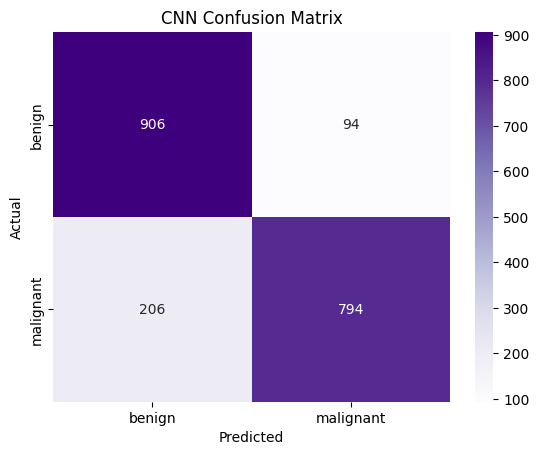

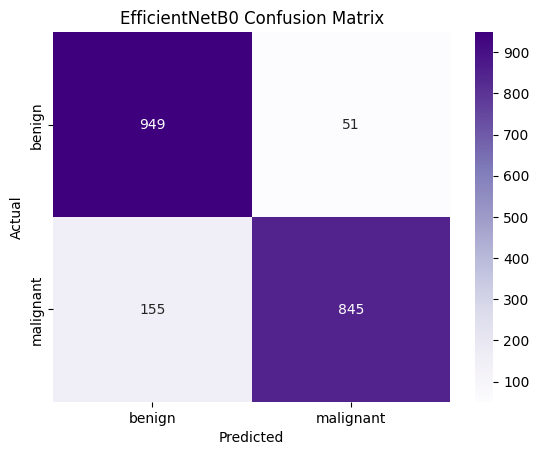

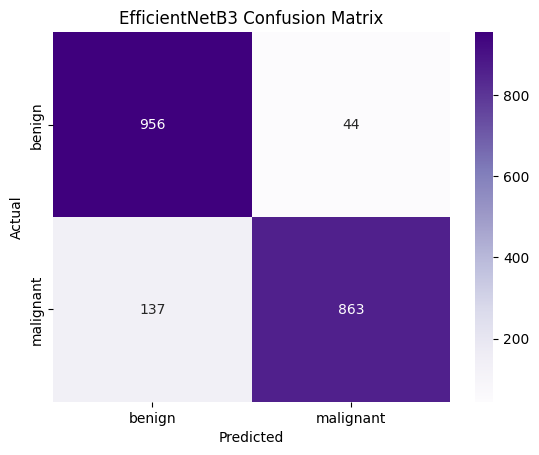

In [ ]:
# Confusion Matrix

# define function to plot confusion matrix
def plot_confustion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=["benign", "malignant"],
                yticklabels=["benign", "malignant"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# plot confusion matrix for all 3 models
plot_confustion_matrix(dataset_true, cnn_pred, "CNN")
plot_confustion_matrix(dataset_true, effnetb0_pred, "EfficientNetB0")
plot_confustion_matrix(ds_true, effnetb3_pred, "EfficientNetB3")

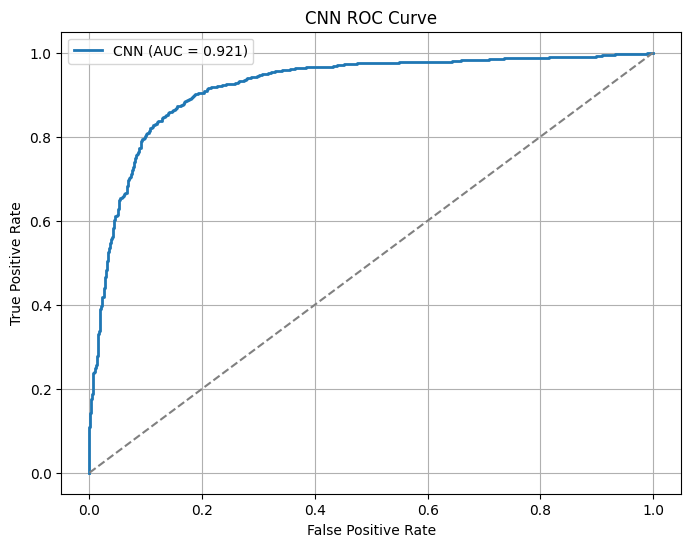

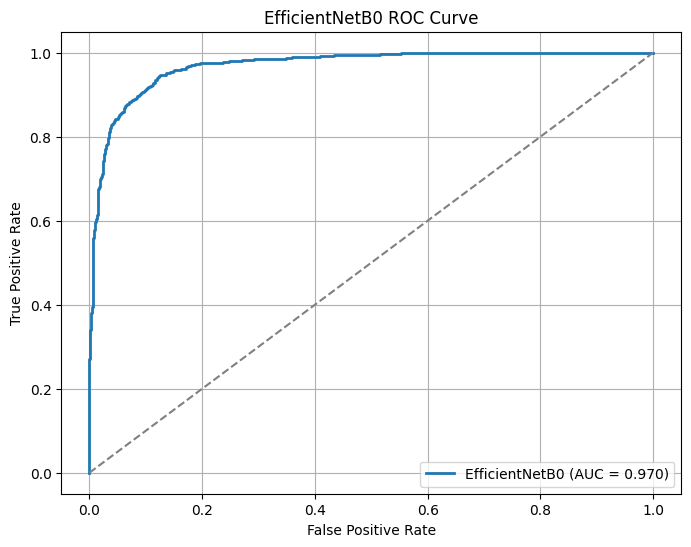

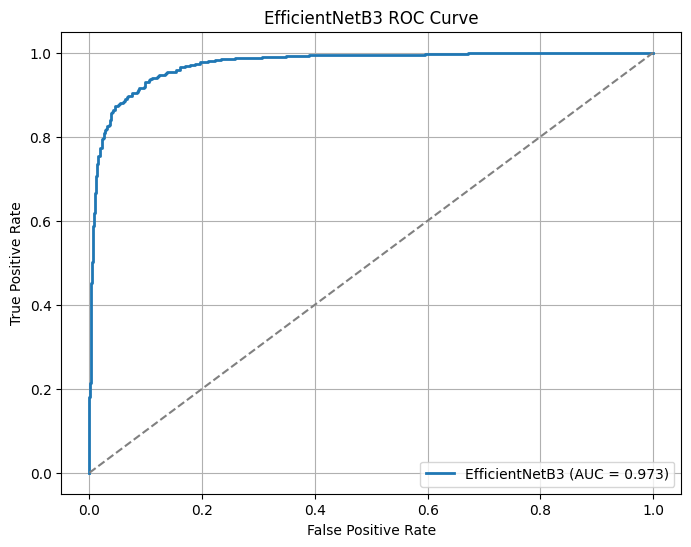

In [ ]:
# define function to plot ROC curve
def plot_roc(y_true, probs, model_name):
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# plot ROC curve for each model
plot_roc(dataset_true, cnn_prob, "CNN")
plot_roc(dataset_true, effnetb0_prob, "EfficientNetB0")
plot_roc(ds_true, effnetb3_prob, "EfficientNetB3")


In [ ]:
# Grad-CAM Heatmap
# https://keras.io/examples/vision/grad_cam

In [79]:
# demo

model = effnetb3_loaded

def predict_b3(image):
    img = np.array(image)
    img = cv2.resize(img, (300, 300))
    img = preprocess_input(img.astype("float32"))
    img = np.expand_dims(img, axis=0)

    prob = model.predict(img)[0][0]
    pred_class = "Malignant" if prob > 0.5 else "Benign"

    return pred_class, float(prob), float(1 - prob)



In [80]:
demo = gr.Interface(
    fn=predict_b3,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=[
        gr.Label(label="Prediction"),
        gr.Number(label="Probability (Malignant)"),
        gr.Number(label="Probability (Benign)")
    ],
    title="Melanoma Detection (EfficientNetB3)",
    description="Upload a skin lesion image to classify into benign vs malignant."
)


In [ ]:
demo.launch()


* Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step


0.23544307


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
